<a href="https://colab.research.google.com/github/zach-gousseau/syde675-project/blob/main/models/675_Project_Polar_Sea_Ice_Prediction_EALSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

## Polar Sea Ice Prediction
Code for Ensemble LSTM model

## Initial Setup

In [2]:
# pip install attention

In [3]:
import os
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy.random import seed

import os
import csv

seed_number = 2
seed(seed_number)

#from attention import Attention

In [4]:
path = '/content/drive/MyDrive/SYDE 675/Project/Data'

daily_data_path = path + '/dailyt30_features.npy'
daily_target_path = path + '/monthly_features.npy'

monthly_data_path = path + '/monthly_features.npy'
monthly_target_path = path + '/monthly_target.npy'

In [5]:
# daily_data = np.load('/.../dailyt30_features.npy',allow_pickle=True)
# monthly_data = np.load('/.../monthly_features.npy',allow_pickle=True)
# daily_target = np.load('/.../dailyt30_target.npy',allow_pickle=True)
# monthly_target = np.load('/.../monthly_target.npy',allow_pickle=True)

daily_data = np.load(daily_data_path, allow_pickle=True)
monthly_data = np.load(monthly_data_path, allow_pickle=True)

daily_target = np.load(daily_target_path, allow_pickle=True)
monthly_target = np.load(monthly_target_path, allow_pickle=True)

In [6]:
print(daily_data.shape)
print(monthly_data.shape)
print(monthly_target.shape)

(480, 30, 11)
(480, 1, 11)
(480,)


In [7]:
# #Removing data after 2020 for SIO Review Paper submission
# daily_data = daily_data[:-7,:,:]
# monthly_data = monthly_data[:-7,:,:]
# monthly_target = monthly_target[:-7]

In [8]:
print(daily_data.shape)
print(monthly_data.shape)
print(monthly_target.shape)

(480, 30, 11)
(480, 1, 11)
(480,)


In [9]:
#Concatenate datasets
data = np.concatenate((daily_data, monthly_data), axis = 1)

print(data.shape)

(480, 31, 11)


In [10]:
#Adding a lag to monthly targets
lag = 1
data = data[:-lag,:,:]
monthly_target = monthly_target[lag:]

print(data.shape)
print(monthly_target.shape)

(479, 31, 11)
(479,)


## Train Validation Features Split

In [11]:
# Sequential split train:val data in 80:20 sequentially 

LEN_DATA = len(data) #total number of pixels

#NUM_TRAIN = LEN_DATA - (24+6) #reserve last 30 months for testing 
# NUM_TRAIN = LEN_DATA - (12*20) #reserve last 20 years for testing 
NUM_TRAIN = LEN_DATA - (12*5) #reserve last 5 years for testing 
NUM_TEST = LEN_DATA - NUM_TRAIN

print('LEN_DATA:',LEN_DATA)
print('NUM_TRAIN:',NUM_TRAIN)
print('NUM_TEST:',NUM_TEST)

x_train = data[0:NUM_TRAIN]
x_test = data[NUM_TRAIN:]

#split features and labels
y_train=monthly_target[:NUM_TRAIN] #target is last column i-e sea-ice
y_test=monthly_target[NUM_TRAIN:] #target is last column i-e sea-ice

LEN_DATA: 479
NUM_TRAIN: 419
NUM_TEST: 60


In [12]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (419, 31, 11)
y_train.shape: (419,)
x_test.shape: (60, 31, 11)
y_test.shape: (60,)


## Normalization


In [13]:
# normalize the features

scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[2])) #reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1,x_test.shape[2])) #reshaping to 2d for standard scaling

scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) #reshaping to 2d for standard scaling



In [14]:
#All data will be in 2D after Standard Scaling
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (12989, 11)
y_train.shape: (419, 1)
x_test.shape: (1860, 11)
y_test.shape: (60, 1)


In [15]:
# convert an array of values into a 3D dataset matrix
def reshape_features(dataset, timesteps=1):
    print(dataset.shape)
    X = dataset.reshape((int(dataset.shape[0]/timesteps)), timesteps, dataset.shape[1])
    return X

In [16]:
#Reshaping data to 3D for modeling
timesteps = 31
x_train = reshape_features(x_train, timesteps) # reshaping to 3d for model
x_test = reshape_features(x_test, timesteps) # reshaping to 3d for model

(12989, 11)
(1860, 11)


In [17]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (419, 31, 11)
y_train.shape: (419, 1)
x_test.shape: (60, 31, 11)
y_test.shape: (60, 1)


## LSTM Network

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import concatenate, Permute, Reshape
from tensorflow.keras.layers import Dense, Lambda, Dot, Activation, Concatenate, Flatten
from tensorflow.keras.layers import Layer

In [19]:
# Customized implementation of Attention layer to accomodate multiple calls to attention
class Attention(Layer):

    def __init__(self, units=128, **kwargs):
        self.units = units
        super().__init__(**kwargs)

    def __call__(self, inputs):
        """
        Many-to-one attention mechanism for Keras.
        @param inputs: 3D tensor with shape (batch_size, time_steps, input_dim).
        @return: 2D tensor with shape (batch_size, 128)
        @author: felixhao28, philipperemy.
        """
        hidden_states = inputs
        hidden_size = int(hidden_states.shape[2])
        # Inside dense layer
        #              hidden_states            dot               W            =>           score_first_part
        # (batch_size, time_steps, hidden_size) dot (hidden_size, hidden_size) => (batch_size, time_steps, hidden_size)
        # W is the trainable weight matrix of attention Luong's multiplicative style score
        score_first_part = Dense(hidden_size, use_bias=False)(hidden_states)
        #            score_first_part           dot        last_hidden_state     => attention_weights
        # (batch_size, time_steps, hidden_size) dot   (batch_size, hidden_size)  => (batch_size, time_steps)
        h_t = Lambda(lambda x: x[:, -1, :], output_shape=(hidden_size,))(hidden_states)
        score = Dot(axes=[1, 2])([h_t, score_first_part])
        attention_weights = Activation('softmax')(score)
        # (batch_size, time_steps, hidden_size) dot (batch_size, time_steps) => (batch_size, hidden_size)
        context_vector = Dot(axes=[1, 1])([hidden_states, attention_weights])
        pre_activation = Concatenate()([context_vector, h_t])
        attention_vector = Dense(self.units, use_bias=False, activation='tanh')(pre_activation)
        return attention_vector

    def get_config(self):
        return {'units': self.units}

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [20]:
model1_input= Input(shape=(30,11)) #replace (30,10) with (30,11) for 11 features 
model2_input= Input(shape=(1,11)) #replace (1,10) with (1,11) for 11 features

model1 = Permute((2,1), input_shape=(30,11))(model1_input)
model1 = LSTM(64, return_sequences=True)(model1)
model1 = Dropout(0.2)(model1)
model1 = LSTM(32, return_sequences=True)(model1)
model1 = Attention()(model1)
model1 = Dense(1)(model1)

model2 = Permute((2,1), input_shape=(1,11))(model2_input)
model2 = LSTM(64, return_sequences=True)(model2)
model2 = Dropout(0.2)(model2)
model2 = LSTM(32, return_sequences=True)(model2)
model2 = Attention()(model2)
model2 = Dense(1)(model2)

ensemble = concatenate([model1, model2])
merged_model = Dense(1)(ensemble)
model = Model(inputs=[model1_input,model2_input], outputs=merged_model)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 11)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 11)]      0           []                               
                                                                                                  
 permute (Permute)              (None, 11, 30)       0           ['input_1[0][0]']                
                                                                                                  
 permute_1 (Permute)            (None, 11, 1)        0           ['input_2[0][0]']                
                                                                                              

## Compiling the Network and Fitting Model

In [21]:
#Compiling the network
model.compile(loss='mean_squared_error', optimizer='adam')
checkpoint_path='./testmodel.h5'
keras_callbacks   = [
      EarlyStopping(monitor='val_loss', patience=60, mode='min', min_delta=0.001),
      ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, mode='min')
]


In [22]:
# history=model.fit([x_train[:,:30,:],x_train[:,30:31,:]], y_train, epochs=500, batch_size=64, verbose=2, validation_split=0.3, shuffle=True,callbacks=keras_callbacks)

# Train on entire dataset

In [23]:
history=model.fit([x_train[:,:30,:], x_train[:,30:31,:]], y_train, epochs=100, batch_size=64, verbose=2, shuffle=True)

Epoch 1/100
7/7 - 15s - loss: 0.4749 - 15s/epoch - 2s/step
Epoch 2/100
7/7 - 0s - loss: 0.1852 - 120ms/epoch - 17ms/step
Epoch 3/100
7/7 - 0s - loss: 0.1225 - 131ms/epoch - 19ms/step
Epoch 4/100
7/7 - 0s - loss: 0.0977 - 118ms/epoch - 17ms/step
Epoch 5/100
7/7 - 0s - loss: 0.0853 - 123ms/epoch - 18ms/step
Epoch 6/100
7/7 - 0s - loss: 0.0745 - 118ms/epoch - 17ms/step
Epoch 7/100
7/7 - 0s - loss: 0.0627 - 123ms/epoch - 18ms/step
Epoch 8/100
7/7 - 0s - loss: 0.0580 - 119ms/epoch - 17ms/step
Epoch 9/100
7/7 - 0s - loss: 0.0517 - 115ms/epoch - 16ms/step
Epoch 10/100
7/7 - 0s - loss: 0.0494 - 123ms/epoch - 18ms/step
Epoch 11/100
7/7 - 0s - loss: 0.0423 - 116ms/epoch - 17ms/step
Epoch 12/100
7/7 - 0s - loss: 0.0431 - 126ms/epoch - 18ms/step
Epoch 13/100
7/7 - 0s - loss: 0.0378 - 119ms/epoch - 17ms/step
Epoch 14/100
7/7 - 0s - loss: 0.0367 - 122ms/epoch - 17ms/step
Epoch 15/100
7/7 - 0s - loss: 0.0330 - 118ms/epoch - 17ms/step
Epoch 16/100
7/7 - 0s - loss: 0.0296 - 127ms/epoch - 18ms/step
Epoc

## Model Predictions

In [24]:
trainPred = model.predict([x_train[:,:30,:],x_train[:,30:31,:]])
testPred = model.predict([x_test[:,:30,:],x_test[:,30:31,:]])
print(testPred.shape)
print(trainPred.shape)

(60, 1)
(419, 1)


In [25]:
#Reverting data back to 2D from 3D
x_train_t = x_train.reshape(-1, x_train.shape[2])
x_test_t = x_test.reshape(-1, x_test.shape[2])

print(x_train_t.shape)
print(trainPred.shape)
print(x_test_t.shape)
print(testPred.shape)

(12989, 11)
(419, 1)
(1860, 11)
(60, 1)


In [26]:
# invert scaling for forecasted values 

inv_testPred = scaler_l.inverse_transform(testPred)
print(inv_testPred)

# invert scaling for actual values

inv_y_test = scaler_l.inverse_transform(y_test)
print(inv_y_test)


[[14494592. ]
 [14887653. ]
 [15189227. ]
 [14633362. ]
 [12776656. ]
 [11736203. ]
 [ 9105661. ]
 [ 5748732.5]
 [ 4987646.5]
 [ 7646420. ]
 [11393866. ]
 [13228309. ]
 [14340829. ]
 [15323602. ]
 [15024797. ]
 [14529716. ]
 [12738922. ]
 [11880212. ]
 [ 9038925. ]
 [ 5648265.5]
 [ 5532380. ]
 [ 7689633. ]
 [11154171. ]
 [13059451. ]
 [14405111. ]
 [15061422. ]
 [15273697. ]
 [14289019. ]
 [13053378. ]
 [11507393. ]
 [ 8192939. ]
 [ 5317645. ]
 [ 4886544. ]
 [ 7176569.5]
 [10025619. ]
 [11881656. ]
 [13740907. ]
 [14345850. ]
 [15022681. ]
 [14192851. ]
 [12432870. ]
 [11608808. ]
 [ 9560164. ]
 [ 5850893. ]
 [ 5014505. ]
 [ 7171694.5]
 [ 9908406. ]
 [12038497. ]
 [13690934. ]
 [15401233. ]
 [14008477. ]
 [14671068. ]
 [12992285. ]
 [11162970. ]
 [ 8804012. ]
 [ 7236592.5]
 [ 5438067. ]
 [ 8350953. ]
 [ 9192643. ]
 [11848018. ]]
[[13859281.]
 [14545530.]
 [14873045.]
 [14251514.]
 [12804783.]
 [11342310.]
 [ 8282561.]
 [ 6226020.]
 [ 5292877.]
 [ 8116325.]
 [10379551.]
 [12587452.]
 [1

In [27]:
# calculate RMSE
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = sqrt(mean_squared_error(inv_y_test, inv_testPred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 659934.300


In [28]:
# calculate Normalized RMSE
y_max = y_test.max()
y_min = y_test.min()
nrmse = rmse /(inv_y_test.mean()) 
print('Test NRMSE:', nrmse)

Test NRMSE: 0.0616411565988182


In [29]:
# calculate R-square
from sklearn.metrics import r2_score
from math import sqrt

r_sq = r2_score(inv_y_test, inv_testPred)
print('Test R_Square: %.3f' % r_sq)

Test R_Square: 0.960


# Write scores in csv files

In [30]:
file_path = '/content/drive/MyDrive/SYDE 675/Project/Models/ea-LSTM/ea_lstm_scores.csv'

header = ['seed', 'Test RMSE', 'Test normalized RMSE', 'R_Square']

if os.path.exists(file_path):
  # If file exists, append row
  with open(file_path, 'a', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the data
    writer.writerow([seed_number, rmse, nrmse, r_sq])

else:
  # If file does not exist, write new file
  with open(file_path, 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    writer.writerow([seed_number, rmse, nrmse, r_sq])

In [37]:
results = pd.read_csv(file_path)
results.describe()

,seed,Test RMSE,Test normalized RMSE,R_Square
count,21.000000,21.000000,21.000000,21.000000
mean,1.476190,618914.229106,0.057810,0.964148
std,0.511766,55528.535575,0.005187,0.006559
min,1.000000,507946.423174,0.047445,0.948826
25%,1.000000,588577.846506,0.054976,0.960888
50%,1.000000,604819.099372,0.056493,0.966023
75%,2.000000,648919.689737,0.060612,0.967823
max,2.000000,742264.260221,0.069331,0.976036


<BarContainer object of 60 artists>

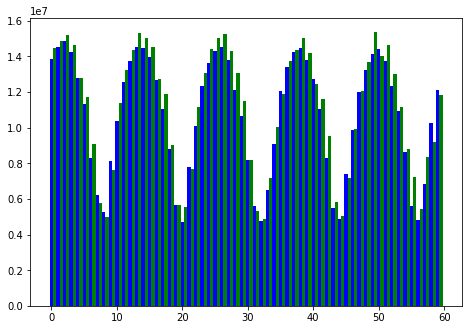

In [31]:
#1 year's plot
import numpy as np
import matplotlib.pyplot as plt
X = np.arange(len(testPred))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, inv_y_test.flatten(), color = 'b', width = 0.5)
ax.bar(X + 0.5, inv_testPred.flatten(), color = 'g', width = 0.5)

In [32]:
len(inv_testPred)

60

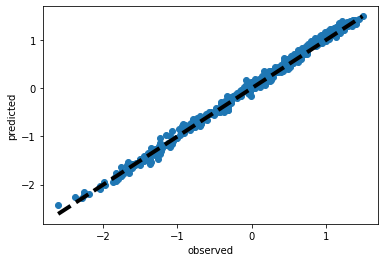

In [33]:
fig, ax = plt.subplots()
ax.scatter(y_train,trainPred)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
plt.show()

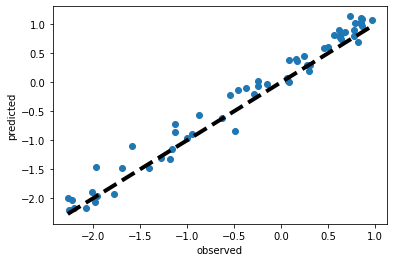

In [34]:
fig, ax = plt.subplots()
ax.scatter(y_test,testPred) #[:,:,6]
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('observed')
ax.set_ylabel('predicted')
#plt.savefig('test_prediction.png',bbox_inches='tight',dpi=1200)
plt.show()

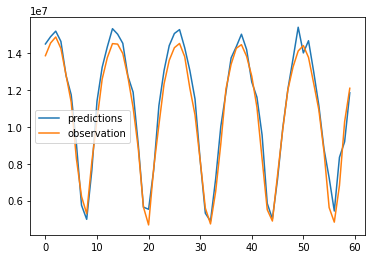

In [35]:
from matplotlib import pyplot

pyplot.plot(inv_testPred, label='predictions')
pyplot.plot(inv_y_test, label='observation')
pyplot.legend()
pyplot.show()

## Plotting

KeyError: ignored

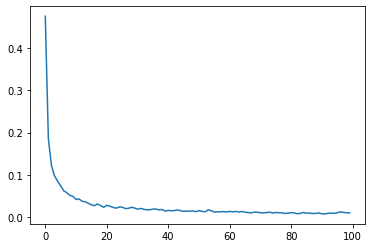

In [36]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()